In [8]:
 Everything in pytorch is based on Tensor operations.
# A tensor can have different dimensions
# so it can be 1d, 2d, or even 3d and higher

# scalar, vector, matrix, tensor

# torch.empty(size): uninitiallized
x = torch.empty(1) # scalar
print(x)
x = torch.empty(3) # vector, 1D
print(x)
x = torch.empty(2,3) # matrix, 2D
print(x)
x = torch.empty(2,2,3) # tensor, 3 dimensions
#x = torch.empty(2,2,2,3) # tensor, 4 dimensions
print(x)

# torch.rand(size): random numbers [0, 1]
x = torch.rand(5, 3)
print(x)

# torch.zeros(size), fill with 0
# torch.ones(size), fill with 1
x = torch.zeros(5, 3)
print(x)

# check size
print(x.size())

# check data type
print(x.dtype)

# specify types, float32 default
x = torch.zeros(5, 3, dtype=torch.float16)
print(x)

# check type
print(x.dtype)

# construct from data
x = torch.tensor([5.5, 3])
print(x.size())

# requires_grad argument
# This will tell pytorch that it will need to calculate the gradients for this tensor
# later in your optimization steps
# i.e. this is a variable in your model that you want to optimize
x = torch.tensor([5.5, 3], requires_grad=True)

# Operations
y = torch.rand(2, 2)
x = torch.rand(2, 2)

# elementwise addition
z = x + y
# torch.add(x,y)

# in place addition, everythin with a trailing underscore is an inplace operation
# i.e. it will modify the variable
# y.add_(x)

# substraction
z = x - y
z = torch.sub(x, y)

# multiplication
z = x * y
z = torch.mul(x,y)

# division
z = x / y
z = torch.div(x,y)

# Slicing
x = torch.rand(5,3)
print(x)
print(x[:, 0]) # all rows, column 0
print(x[1, :]) # row 1, all columns
print(x[1,1]) # element at 1, 1

# Get the actual value if only 1 element in your tensor
print(x[1,1].item())

# Reshape with torch.view()
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
# if -1 it pytorch will automatically determine the necessary size
print(x.size(), y.size(), z.size())

# Numpy
# Converting a Torch Tensor to a NumPy array and vice versa is very easy
a = torch.ones(5)
print(a)

# torch to numpy with .numpy()
b = a.numpy()
print(b)
print(type(b))

# Carful: If the Tensor is on the CPU (not the GPU),
# both objects will share the same memory location, so changing one
# will also change the other
a.add_(1)
print(a)
print(b)

# numpy to torch with .from_numpy(x)
import numpy as np
a = np.ones(5)
b = torch.from_numpy(a)
print(a)
print(b)

# again be careful when modifying
a += 1
print(a)
print(b)

# by default all tensors are created on the CPU,
# but you can also move them to the GPU (only if it's available )
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings ``.to("cuda")``
    z = x + y
    # z = z.numpy() # not possible because numpy cannot handle GPU tenors
    # move to CPU again
    z.to("cpu")       # ``.to`` can also change dtype together!
    # z = z.numpy()

In [4]:
import cv2

In [ ]:
# The autograd package provides automatic differentiation 
# for all operations on Tensors

# requires_grad = True -> tracks all operations on the tensor. 
x = torch.randn(3, requires_grad=True)
y = x + 2

# y was created as a result of an operation, so it has a grad_fn attribute.
# grad_fn: references a Function that has created the Tensor
print(x) # created by the user -> grad_fn is None
print(y)
print(y.grad_fn)

# Do more operations on y
z = y * y * 3
print(z)
z = z.mean()
print(z)

# Let's compute the gradients with backpropagation
# When we finish our computation we can call .backward() and have all the gradients computed automatically.
# The gradient for this tensor will be accumulated into .grad attribute.
# It is the partial derivate of the function w.r.t. the tensor

z.backward()
print(x.grad) # dz/dx

# Generally speaking, torch.autograd is an engine for computing vector-Jacobian product
# It computes partial derivates while applying the chain rule

# -------------
# Model with non-scalar output:
# If a Tensor is non-scalar (more than 1 elements), we need to specify arguments for backward() 
# specify a gradient argument that is a tensor of matching shape.
# needed for vector-Jacobian product

x = torch.randn(3, requires_grad=True)

y = x * 2
for _ in range(10):
    y = y * 2

print(y)
print(y.shape)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float32)
y.backward(v)
print(x.grad)

# -------------
# Stop a tensor from tracking history:
# For example during our training loop when we want to update our weights
# then this update operation should not be part of the gradient computation
# - x.requires_grad_(False)
# - x.detach()
# - wrap in 'with torch.no_grad():'

# .requires_grad_(...) changes an existing flag in-place.
a = torch.randn(2, 2)
print(a.requires_grad)
b = ((a * 3) / (a - 1))
print(b.grad_fn)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

# .detach(): get a new Tensor with the same content but no gradient computation:
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)
b = a.detach()
print(b.requires_grad)

# wrap in 'with torch.no_grad():'
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)
with torch.no_grad():
    print((x ** 2).requires_grad)

# -------------
# backward() accumulates the gradient for this tensor into .grad attribute.
# !!! We need to be careful during optimization !!!
# Use .zero_() to empty the gradients before a new optimization step!
weights = torch.ones(4, requires_grad=True)

for epoch in range(3):
    # just a dummy example
    model_output = (weights*3).sum()
    model_output.backward()
    
    print(weights.grad)

    # optimize model, i.e. adjust weights...
    with torch.no_grad():
        weights -= 0.1 * weights.grad

    # this is important! It affects the final weights & output
    weights.grad.zero_()

print(weights)
print(model_output)

# Optimizer has zero_grad() method
# optimizer = torch.optim.SGD([weights], lr=0.1)
# During training:
# optimizer.step()
# optimizer.zero_grad()

In [1]:
import torch

In [11]:
x = torch.randn(3, requires_grad=True)
y = x + 2

In [13]:
z = y*y*2

In [14]:
z = z.mean()

In [20]:
z.backward()

In [22]:
x.grad

tensor([3.1390, 2.9838, 0.1676])

# Gradient Descent with Autograd and Backpropagation

In [1]:
import torch
import numpy as np

In [2]:
# Linear regression
# f = w * x 

# here : f = 2 * x
X = np.array([1, 2, 3, 4], dtype=np.float32)
Y = np.array([2, 4, 6, 8], dtype=np.float32)

w = 0.0

In [3]:
# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

In [4]:
# J = MSE = 1/N * (w*x - y)**2
# dJ/dw = 1/N * 2x(w*x - y)
def gradient(x, y, y_pred):
    return np.dot(2*x, y_pred - y).mean()

In [ ]:
print(f'Prediction before training: f(5) = {forward(5):.3f}')

In [ ]:
# Training
learning_rate = 0.01
n_iters = 20

for epoch in range(n_iters):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)
    
    # calculate gradients
    dw = gradient(X, Y, y_pred)

    # update weights
    w -= learning_rate * dw

    if epoch % 2 == 0:
        print(f'epoch {epoch+1}: w = {w:.3f}, loss = {l:.8f}')
     
print(f'Prediction after training: f(5) = {forward(5):.3f}')

In [ ]:
import torch

# Here we replace the manually computed gradient with autograd

# Linear regression
# f = w * x 

# here : f = 2 * x
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

print(f'Prediction before training: f(5) = {forward(5).item():.3f}')

# Training
learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    #w.data = w.data - learning_rate * w.grad
    with torch.no_grad():
        w -= learning_rate * w.grad
    
    # zero the gradients after updating
    w.grad.zero_()

    if epoch % 10 == 0:
        print(f'epoch {epoch+1}: w = {w.item():.3f}, loss = {l.item():.8f}')

print(f'Prediction after training: f(5) = {forward(5).item():.3f}')

In [ ]:
# 1) Design model (input, output, forward pass with different layers)
# 2) Construct loss and optimizer
# 3) Training loop
#       - Forward = compute prediction and loss
#       - Backward = compute gradients
#       - Update weights

import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

# 1) Design Model: Weights to optimize and forward function
w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

def forward(x):
    return w * x

print(f'Prediction before training: f(5) = {forward(5).item():.3f}')

# 2) Define loss and optimizer
learning_rate = 0.01
n_iters = 100

# callable function
loss = nn.MSELoss()

optimizer = torch.optim.SGD([w], lr=learning_rate)

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass
    y_predicted = forward(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:
        print('epoch ', epoch+1, ': w = ', w, ' loss = ', l)

print(f'Prediction after training: f(5) = {forward(5).item():.3f}')

In [ ]:
# 1) Design model (input, output, forward pass with different layers)
# 2) Construct loss and optimizer
# 3) Training loop
#       - Forward = compute prediction and loss
#       - Backward = compute gradients
#       - Update weights

import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples, watch the shape!
X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

n_samples, n_features = X.shape
print(f'#samples: {n_samples}, #features: {n_features}')
# 0) create a test sample
X_test = torch.tensor([5], dtype=torch.float32)

# 1) Design Model, the model has to implement the forward pass!
# Here we can use a built-in model from PyTorch
input_size = n_features
output_size = n_features

# we can call this model with samples X
model = nn.Linear(input_size, output_size)

'''
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        # define diferent layers
        self.lin = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.lin(x)
model = LinearRegression(input_size, output_size)
'''

print(f'Prediction before training: f(5) = {model(X_test).item():.3f}')

# 2) Define loss and optimizer
learning_rate = 0.01
n_iters = 100

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass with our model
    y_predicted = model(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:
        [w, b] = model.parameters() # unpack parameters
        print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l)

print(f'Prediction after training: f(5) = {model(X_test).item():.3f}')

## Linear regression

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

# 0) Prepare data
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)

# cast to float Tensor
X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape

# 1) Model
# Linear model f = wx + b
input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# 3) Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    
    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

# Plot
predicted = model(X).detach().numpy()

plt.plot(X_numpy, y_numpy, 'ro')
plt.plot(X_numpy, predicted, 'b')
plt.show()

## Logistic regression

In [27]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [28]:
# 0) Prepare data
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

In [29]:
bc.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [30]:
n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [31]:
# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [32]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [33]:
y_train

tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
        1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
        0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 0., 

In [34]:
y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

In [35]:
# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

In [50]:
# 2) Loss and optimizer
num_epochs = 10000
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [51]:
# 3) Training loop
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


y_predicted = model(X_test)
y_predicted_cls = y_predicted.round()
acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
print(f'accuracy: {acc.item():.4f}')

epoch: 10, loss = 0.0791
epoch: 20, loss = 0.0788
epoch: 30, loss = 0.0786
epoch: 40, loss = 0.0784
epoch: 50, loss = 0.0782
epoch: 60, loss = 0.0780
epoch: 70, loss = 0.0778
epoch: 80, loss = 0.0775
epoch: 90, loss = 0.0773
epoch: 100, loss = 0.0771
epoch: 110, loss = 0.0769
epoch: 120, loss = 0.0767
epoch: 130, loss = 0.0765
epoch: 140, loss = 0.0763
epoch: 150, loss = 0.0761
epoch: 160, loss = 0.0759
epoch: 170, loss = 0.0758
epoch: 180, loss = 0.0756
epoch: 190, loss = 0.0754
epoch: 200, loss = 0.0752
epoch: 210, loss = 0.0750
epoch: 220, loss = 0.0748
epoch: 230, loss = 0.0747
epoch: 240, loss = 0.0745
epoch: 250, loss = 0.0743
epoch: 260, loss = 0.0741
epoch: 270, loss = 0.0740
epoch: 280, loss = 0.0738
epoch: 290, loss = 0.0736
epoch: 300, loss = 0.0735
epoch: 310, loss = 0.0733
epoch: 320, loss = 0.0731
epoch: 330, loss = 0.0730
epoch: 340, loss = 0.0728
epoch: 350, loss = 0.0726
epoch: 360, loss = 0.0725
epoch: 370, loss = 0.0723
epoch: 380, loss = 0.0722
epoch: 390, loss = 0.

epoch: 3250, loss = 0.0517
epoch: 3260, loss = 0.0516
epoch: 3270, loss = 0.0516
epoch: 3280, loss = 0.0516
epoch: 3290, loss = 0.0515
epoch: 3300, loss = 0.0515
epoch: 3310, loss = 0.0514
epoch: 3320, loss = 0.0514
epoch: 3330, loss = 0.0514
epoch: 3340, loss = 0.0513
epoch: 3350, loss = 0.0513
epoch: 3360, loss = 0.0513
epoch: 3370, loss = 0.0512
epoch: 3380, loss = 0.0512
epoch: 3390, loss = 0.0512
epoch: 3400, loss = 0.0511
epoch: 3410, loss = 0.0511
epoch: 3420, loss = 0.0511
epoch: 3430, loss = 0.0510
epoch: 3440, loss = 0.0510
epoch: 3450, loss = 0.0510
epoch: 3460, loss = 0.0509
epoch: 3470, loss = 0.0509
epoch: 3480, loss = 0.0509
epoch: 3490, loss = 0.0508
epoch: 3500, loss = 0.0508
epoch: 3510, loss = 0.0508
epoch: 3520, loss = 0.0507
epoch: 3530, loss = 0.0507
epoch: 3540, loss = 0.0507
epoch: 3550, loss = 0.0506
epoch: 3560, loss = 0.0506
epoch: 3570, loss = 0.0506
epoch: 3580, loss = 0.0505
epoch: 3590, loss = 0.0505
epoch: 3600, loss = 0.0505
epoch: 3610, loss = 0.0504
e

epoch: 6390, loss = 0.0439
epoch: 6400, loss = 0.0439
epoch: 6410, loss = 0.0438
epoch: 6420, loss = 0.0438
epoch: 6430, loss = 0.0438
epoch: 6440, loss = 0.0438
epoch: 6450, loss = 0.0438
epoch: 6460, loss = 0.0438
epoch: 6470, loss = 0.0437
epoch: 6480, loss = 0.0437
epoch: 6490, loss = 0.0437
epoch: 6500, loss = 0.0437
epoch: 6510, loss = 0.0437
epoch: 6520, loss = 0.0437
epoch: 6530, loss = 0.0436
epoch: 6540, loss = 0.0436
epoch: 6550, loss = 0.0436
epoch: 6560, loss = 0.0436
epoch: 6570, loss = 0.0436
epoch: 6580, loss = 0.0435
epoch: 6590, loss = 0.0435
epoch: 6600, loss = 0.0435
epoch: 6610, loss = 0.0435
epoch: 6620, loss = 0.0435
epoch: 6630, loss = 0.0435
epoch: 6640, loss = 0.0434
epoch: 6650, loss = 0.0434
epoch: 6660, loss = 0.0434
epoch: 6670, loss = 0.0434
epoch: 6680, loss = 0.0434
epoch: 6690, loss = 0.0434
epoch: 6700, loss = 0.0433
epoch: 6710, loss = 0.0433
epoch: 6720, loss = 0.0433
epoch: 6730, loss = 0.0433
epoch: 6740, loss = 0.0433
epoch: 6750, loss = 0.0433
e

epoch: 9580, loss = 0.0395
epoch: 9590, loss = 0.0395
epoch: 9600, loss = 0.0395
epoch: 9610, loss = 0.0395
epoch: 9620, loss = 0.0395
epoch: 9630, loss = 0.0395
epoch: 9640, loss = 0.0395
epoch: 9650, loss = 0.0394
epoch: 9660, loss = 0.0394
epoch: 9670, loss = 0.0394
epoch: 9680, loss = 0.0394
epoch: 9690, loss = 0.0394
epoch: 9700, loss = 0.0394
epoch: 9710, loss = 0.0394
epoch: 9720, loss = 0.0394
epoch: 9730, loss = 0.0394
epoch: 9740, loss = 0.0393
epoch: 9750, loss = 0.0393
epoch: 9760, loss = 0.0393
epoch: 9770, loss = 0.0393
epoch: 9780, loss = 0.0393
epoch: 9790, loss = 0.0393
epoch: 9800, loss = 0.0393
epoch: 9810, loss = 0.0393
epoch: 9820, loss = 0.0393
epoch: 9830, loss = 0.0393
epoch: 9840, loss = 0.0392
epoch: 9850, loss = 0.0392
epoch: 9860, loss = 0.0392
epoch: 9870, loss = 0.0392
epoch: 9880, loss = 0.0392
epoch: 9890, loss = 0.0392
epoch: 9900, loss = 0.0392
epoch: 9910, loss = 0.0392
epoch: 9920, loss = 0.0392
epoch: 9930, loss = 0.0392
epoch: 9940, loss = 0.0391
e

## Dataset and Data Loader

In [33]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import pandas as pd

In [57]:
# gradient computation etc. not efficient for whole data set
# -> divide dataset into small batches

'''
# training loop
for epoch in range(num_epochs):
    # loop over all batches
    for i in range(total_batches):
        batch_x, batch_y = ...
'''

# epoch = one forward and backward pass of ALL training samples
# batch_size = number of training samples used in one forward/backward pass
# number of iterations = number of passes, each pass (forward+backward) using [batch_size] number of sampes
# e.g : 100 samples, batch_size=20 -> 100/20=5 iterations for 1 epoch

# --> DataLoader can do the batch computation for us

# Implement a custom Dataset:
# inherit Dataset
# implement __init__ , __getitem__ , and __len__

class WineDataset(Dataset):

    def __init__(self):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = pd.read_table('wine.TXT', delimiter=',', dtype=np.float32)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy.iloc[:,1:].to_numpy()) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(xy['Wine'].to_numpy()) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [60]:
len(dataset)

178

In [58]:
dataset = WineDataset()

In [23]:
# get first sample and unpack
first_data = dataset[0]
features, labels = first_data
print(features, labels)

tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) tensor([1.])


In [77]:
# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=0)

In [80]:
features.shape

torch.Size([4, 13])

In [81]:
# convert to an iterator and look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print(features, labels)

# Dummy Training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)

tensor([[1.3720e+01, 1.4300e+00, 2.5000e+00, 1.6700e+01, 1.0800e+02, 3.4000e+00,
         3.6700e+00, 1.9000e-01, 2.0400e+00, 6.8000e+00, 8.9000e-01, 2.8700e+00,
         1.2850e+03],
        [1.2250e+01, 1.7300e+00, 2.1200e+00, 1.9000e+01, 8.0000e+01, 1.6500e+00,
         2.0300e+00, 3.7000e-01, 1.6300e+00, 3.4000e+00, 1.0000e+00, 3.1700e+00,
         5.1000e+02],
        [1.1460e+01, 3.7400e+00, 1.8200e+00, 1.9500e+01, 1.0700e+02, 3.1800e+00,
         2.5800e+00, 2.4000e-01, 3.5800e+00, 2.9000e+00, 7.5000e-01, 2.8100e+00,
         5.6200e+02],
        [1.3240e+01, 2.5900e+00, 2.8700e+00, 2.1000e+01, 1.1800e+02, 2.8000e+00,
         2.6900e+00, 3.9000e-01, 1.8200e+00, 4.3200e+00, 1.0400e+00, 2.9300e+00,
         7.3500e+02]]) tensor([1., 2., 2., 1.])
178 45


In [82]:
for epoch in range(num_epochs):
    for i,(features, labels) in enumerate(train_loader):
        #print(i, (features, labels))
        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')

# some famous datasets are available in torchvision.datasets
# e.g. MNIST, Fashion-MNIST, CIFAR10, COCO

train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),  
                                           download=True)

train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=3, 
                                           shuffle=True)

# look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
inputs, targets = data
print(inputs.shape, targets.shape)

Epoch: 1/2, Step 5/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 10/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 15/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 20/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 25/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 30/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 35/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 40/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 1/2, Step 45/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([2])
Epoch: 2/2, Step 5/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 2/2, Step 10/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch: 2/2, Step 15/45| Inputs torch.Size([3, 1, 28, 28]) | Labels torch.Size([4])
Epoch:

In [64]:
enumerate(train_loader)

## Softmax and cross entropy for multi class classification

In [1]:
import torch
import torch.nn as nn
import numpy as np

#
#        -> 2.0              -> 0.65  
# Linear -> 1.0  -> Softmax  -> 0.25   -> CrossEntropy(y, y_hat)
#        -> 0.1              -> 0.1                   
#
#     scores(logits)      probabilities
#                           sum = 1.0
#

# Softmax applies the exponential function to each element, and normalizes
# by dividing by the sum of all these exponentials
# -> squashes the output to be between 0 and 1 = probability
# sum of all probabilities is 1

In [ ]:
np.exp()

In [86]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

x = np.array([2.0, 1.0, 0.1])
outputs = softmax(x)
print('softmax numpy:', outputs)

x = torch.tensor([2.0, 1.0, 0.1])
outputs = torch.softmax(x, dim=0) # along values along first axis
print('softmax torch:', outputs)

softmax numpy: [0.65900114 0.24243297 0.09856589]
softmax torch: tensor([0.6590, 0.2424, 0.0986])


In [87]:
# Cross entropy
# Cross-entropy loss, or log loss, measures the performance of a classification model 
# whose output is a probability value between 0 and 1. 
# -> loss increases as the predicted probability diverges from the actual label
def cross_entropy(actual, predicted):
    EPS = 1e-15
    predicted = np.clip(predicted, EPS, 1 - EPS)
    loss = -np.sum(actual * np.log(predicted))
    return loss # / float(predicted.shape[0])

In [ ]:
# y must be one hot encoded
# if class 0: [1 0 0]
# if class 1: [0 1 0]
# if class 2: [0 0 1]
Y = np.array([1, 0, 0])
Y_pred_good = np.array([0.7, 0.2, 0.1])
Y_pred_bad = np.array([0.1, 0.3, 0.6])
l1 = cross_entropy(Y, Y_pred_good)
l2 = cross_entropy(Y, Y_pred_bad)
print(f'Loss1 numpy: {l1:.4f}')
print(f'Loss2 numpy: {l2:.4f}')

In [2]:
# CrossEntropyLoss in PyTorch (applies Softmax)
# nn.LogSoftmax + nn.NLLLoss
# NLLLoss = negative log likelihood loss
loss = nn.CrossEntropyLoss()
# loss(input, target)

# target is of size nSamples = 1
# each element has class label: 0, 1, or 2
# Y (=target) contains class labels, not one-hot
Y = torch.tensor([0])

# input is of size nSamples x nClasses = 1 x 3
# y_pred (=input) must be raw, unnormalizes scores (logits) for each class, not softmax
Y_pred_good = torch.tensor([[2.0, 1.0, 0.1]])
Y_pred_bad = torch.tensor([[0.5, 2.0, 0.3]])
l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)

print(f'PyTorch Loss1: {l1.item():.4f}')
print(f'PyTorch Loss2: {l2.item():.4f}')

PyTorch Loss1: 0.4170
PyTorch Loss2: 1.8406


In [3]:
# get predictions
_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)
print(f'Actual class: {Y.item()}, Y_pred1: {predictions1.item()}, Y_pred2: {predictions2.item()}')

Actual class: 0, Y_pred1: 0, Y_pred2: 1


In [4]:
# allows batch loss for multiple samples

# target is of size nBatch = 3
# each element has class label: 0, 1, or 2
Y = torch.tensor([2, 0, 1])

# input is of size nBatch x nClasses = 3 x 3
# Y_pred are logits (not softmax)
Y_pred_good = torch.tensor(
    [[0.1, 0.2, 3.9], # predict class 2
    [1.2, 0.1, 0.3], # predict class 0
    [0.3, 2.2, 0.2]]) # predict class 1

Y_pred_bad = torch.tensor(
    [[0.9, 0.2, 0.1],
    [0.1, 0.3, 1.5],
    [1.2, 0.2, 0.5]])

l1 = loss(Y_pred_good, Y)
l2 = loss(Y_pred_bad, Y)
print(f'Batch Loss1:  {l1.item():.4f}')
print(f'Batch Loss2: {l2.item():.4f}')

# get predictions
_, predictions1 = torch.max(Y_pred_good, 1)
_, predictions2 = torch.max(Y_pred_bad, 1)
print(f'Actual class: {Y}, Y_pred1: {predictions1}, Y_pred2: {predictions2}')

Batch Loss1:  0.2834
Batch Loss2: 1.6418
Actual class: tensor([2, 0, 1]), Y_pred1: tensor([2, 0, 1]), Y_pred2: tensor([0, 2, 0])


In [ ]:
# Binary classification
class NeuralNet1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet1, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)#activation
        out = self.linear2(out)
        # sigmoid at the end
        y_pred = torch.sigmoid(out)
        return y_pred

model = NeuralNet1(input_size=28*28, hidden_size=5)
criterion = nn.BCELoss()

# Multiclass problem
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()#activation
        self.linear2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # no softmax at the end
        return out

model = NeuralNet2(input_size=28*28, hidden_size=5, num_classes=3)
criterion = nn.CrossEntropyLoss()  # (applies Softmax)

## Activation function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.tensor([-1.0, 1.0, 2.0, 3.0])

# sofmax
output = torch.softmax(x, dim=0)
print(output)
sm = nn.Softmax(dim=0)
output = sm(x)
print(output)

# sigmoid 
output = torch.sigmoid(x)
print(output)
s = nn.Sigmoid()
output = s(x)
print(output)

#tanh
output = torch.tanh(x)
print(output)
t = nn.Tanh()
output = t(x)
print(output)

# relu
output = torch.relu(x)
print(output)
relu = nn.ReLU()
output = relu(x)
print(output)

# leaky relu
output = F.leaky_relu(x)
print(output)
lrelu = nn.LeakyReLU()
output = lrelu(x)
print(output)

#nn.ReLU() creates an nn.Module which you can add e.g. to an nn.Sequential model.
#torch.relu on the other side is just the functional API call to the relu function,
#so that you can add it e.g. in your forward method yourself.

In [ ]:
# option 1 (create nn modules)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

# option 2 (use activation functions directly in forward pass)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = torch.relu(self.linear1(x))
        out = torch.sigmoid(self.linear2(out))
        return out

## Feed forward

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [5]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

In [6]:
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

In [9]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [12]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

In [13]:
examples

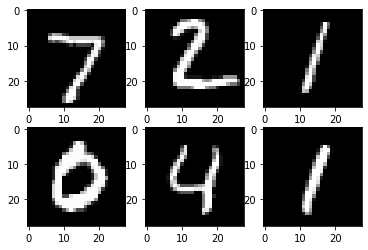

In [14]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [15]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [16]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [23]:
for images, labels in train_loader:
    print(labels.shape)

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

In [28]:
train_loader

In [26]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i,(images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.0496
Epoch [1/2], Step [200/600], Loss: 0.0194
Epoch [1/2], Step [300/600], Loss: 0.0241
Epoch [1/2], Step [400/600], Loss: 0.0459
Epoch [1/2], Step [500/600], Loss: 0.0572
Epoch [1/2], Step [600/600], Loss: 0.0376
Epoch [2/2], Step [100/600], Loss: 0.0258
Epoch [2/2], Step [200/600], Loss: 0.0115
Epoch [2/2], Step [300/600], Loss: 0.0181
Epoch [2/2], Step [400/600], Loss: 0.0038
Epoch [2/2], Step [500/600], Loss: 0.0295
Epoch [2/2], Step [600/600], Loss: 0.0472


In [18]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.05 %


##  Convolutional Neural Network (CNN)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 20
batch_size = 4
learning_rate = 0.001

In [5]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

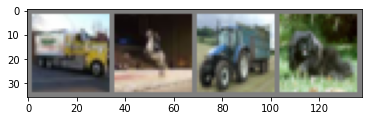

In [7]:
# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
conv1 = nn.Conv2d(3,6,5)

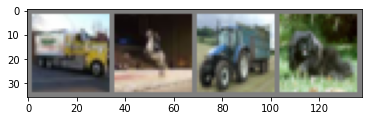

In [11]:
imshow(torchvision.utils.make_grid(images))

In [13]:
x = conv1(images)

In [14]:
x.shape

torch.Size([4, 6, 28, 28])

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn2.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/20], Step [2000/12500], Loss: 0.8529
Epoch [1/20], Step [4000/12500], Loss: 1.0773
Epoch [1/20], Step [6000/12500], Loss: 1.3882
Epoch [1/20], Step [8000/12500], Loss: 0.9873
Epoch [1/20], Step [10000/12500], Loss: 1.7858
Epoch [1/20], Step [12000/12500], Loss: 0.5687
Epoch [2/20], Step [2000/12500], Loss: 0.8159
Epoch [2/20], Step [4000/12500], Loss: 1.2168
Epoch [2/20], Step [6000/12500], Loss: 1.0022
Epoch [2/20], Step [8000/12500], Loss: 2.1209
Epoch [2/20], Step [10000/12500], Loss: 1.1430
Epoch [2/20], Step [12000/12500], Loss: 1.3973
Epoch [3/20], Step [2000/12500], Loss: 1.4987
Epoch [3/20], Step [4000/12500], Loss: 2.4225
Epoch [3/20], Step [6000/12500], Loss: 1.2568
Epoch [3/20], Step [8000/12500], Loss: 1.0361
Epoch [3/20], Step [10000/12500], Loss: 0.9556
Epoch [3/20], Step [12000/12500], Loss: 0.6221
Epoch [4/20], Step [2000/12500], Loss: 0.9638
Epoch [4/20], Step [4000/12500], Loss: 0.8315
Epoch [4/20], Step [6000/12500], Loss: 1.0244
Epoch [4/20], Step [8000/125

In [23]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 64.23 %
Accuracy of plane: 72.5 %
Accuracy of car: 72.2 %
Accuracy of bird: 42.6 %
Accuracy of cat: 50.2 %
Accuracy of deer: 68.7 %
Accuracy of dog: 48.3 %
Accuracy of frog: 68.0 %
Accuracy of horse: 66.8 %
Accuracy of ship: 77.2 %
Accuracy of truck: 75.8 %


## Transfer learning

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [25]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
print(class_names)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'data/hymenoptera_data\\train'

In [ ]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [2]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\erik6/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


In [3]:
model.fc.

512

In [6]:
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

## Tensorboard

In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [23]:
############## TENSORBOARD ########################
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist1')
###################################################

In [27]:
torch.cuda.is_available()

True

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
device

device(type='cuda')

In [15]:

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 500 
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

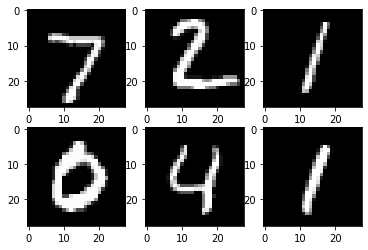

In [31]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()

In [32]:
############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
#writer.close()
#sys.exit()
###################################################

In [35]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

model = NeuralNet(input_size, hidden_size, num_classes)

In [36]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

############## TENSORBOARD ########################
writer.add_graph(model, example_data.reshape(-1, 28*28))
#writer.close()
#sys.exit()
###################################################

In [18]:
# Train the model
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            ###################################################

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(predicted)

    # 10000, 10, and 10000, 1
    # stack concatenates tensors along a new dimension
    # cat concatenates tensors in the given dimension
    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    ############## TENSORBOARD ########################
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()
    ###################################################

Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)
Error occurs, No graph saved


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

# andreiliphd

In [10]:
X = torch.randn([1,100,3])
target = torch.randn([1,100,64])

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1=torch.nn.Linear(3,64)
    def forward(self,x):
        x = self.fc1(x)
        return(x)

In [7]:
Model = Net()

In [26]:
par = list(Model.parameters())# w and b

In [29]:
par[0].shape

torch.Size([64, 3])

In [30]:
par[0].T.shape

torch.Size([3, 64])

In [38]:
X.matmul(par[0].T).shape #то что делает model(x)

torch.Size([1, 100, 64])

In [12]:
Model(X).shape

torch.Size([1, 100, 64])

In [13]:
criterion = torch.nn.MSELoss()

In [21]:
optimiser = torch.optim.SGD(Model.parameters(),lr=0.05)

In [22]:
for epoch in range(100):
    output = Model(X)
    loss = criterion(output,target)
    print('Epoch: ',epoch,'Loss: ',loss.item())
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch:  0 Loss:  1.4599412679672241
Epoch:  1 Loss:  1.4583613872528076
Epoch:  2 Loss:  1.4567867517471313
Epoch:  3 Loss:  1.4552178382873535
Epoch:  4 Loss:  1.4536545276641846
Epoch:  5 Loss:  1.4520962238311768
Epoch:  6 Loss:  1.4505438804626465
Epoch:  7 Loss:  1.4489965438842773
Epoch:  8 Loss:  1.447454810142517
Epoch:  9 Loss:  1.4459185600280762
Epoch:  10 Loss:  1.444387674331665
Epoch:  11 Loss:  1.4428619146347046
Epoch:  12 Loss:  1.441341519355774
Epoch:  13 Loss:  1.439826488494873
Epoch:  14 Loss:  1.4383169412612915
Epoch:  15 Loss:  1.436812400817871
Epoch:  16 Loss:  1.4353132247924805
Epoch:  17 Loss:  1.4338191747665405
Epoch:  18 Loss:  1.4323304891586304
Epoch:  19 Loss:  1.4308468103408813
Epoch:  20 Loss:  1.4293686151504517
Epoch:  21 Loss:  1.4278953075408936
Epoch:  22 Loss:  1.4264271259307861
Epoch:  23 Loss:  1.4249643087387085
Epoch:  24 Loss:  1.423506259918213
Epoch:  25 Loss:  1.4220536947250366
Epoch:  26 Loss:  1.4206057786941528
Epoch:  27 Loss: 

# Tensorflow

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tensorflow as tf

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True